In [1]:
import os
import time
import random
import warnings

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

# Data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Pretrained models and segmentation utilities
import timm  # Vision Transformers
import segmentation_models_pytorch as smp  # DiceLoss, etc.

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)


C:\Users\TerraTech\anaconda3\envs\torch_env\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def load_model(model_path, device='cuda'):  
    """
    Loads a segmentation model from a saved checkpoint.

    Args:
        model_path (str): Path to the saved model file.
        device (str): Device to load the model onto ('cuda' or 'cpu').

    Returns:
        torch.nn.Module: The loaded model.
    """
    state_dict = torch.load(model_path, map_location=device, weights_only=True)   
    model.load_state_dict(state_dict)    
    model.to(device)    
    return model

def compute_metrics(model_path, dataloader, device='cuda', threshold=0.5):
    """
    Computes evaluation metrics for a segmentation model, excluding all-zero cases.
    """
    model = load_model(model_path, device=device)
    model.eval()

    total_tp = total_fp = total_fn = total_tn = 0
    valid_pixels = 0  # Track total valid pixels for averaging

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            logits = model(images)
            if logits.shape[-2:] != masks.shape[-2:]:
                logits = F.interpolate(logits, size=masks.shape[-2:], 
                                     mode="bilinear", align_corners=False)
            
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).float()
            
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            
            tp = torch.sum(preds_flat * masks_flat)
            fp = torch.sum(preds_flat * (1 - masks_flat))
            tn = torch.sum((1 - preds_flat) * (1 - masks_flat))
            fn = torch.sum((1 - preds_flat) * masks_flat)
            
            # Only include in totals if not an all-zero case (TP + FP + FN > 0)
            if tp + fp + fn > 0:
                total_tp += tp.item()
                total_fp += fp.item()
                total_tn += tn.item()
                total_fn += fn.item()
                valid_pixels += len(preds_flat)

    # If no valid cases, return zeros
    if valid_pixels == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0

    # Compute metrics using only valid cases
    mIOU = total_tp / (total_tp + total_fp + total_fn + 1e-6)
    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2.0 * precision * recall / (precision + recall + 1e-6)
    accuracy = (total_tp + total_tn) / (total_tp + total_fp + total_tn + total_fn + 1e-6)

    return mIOU, f1, precision, recall, accuracy

def get_contours(mask):
    """
    Extracts contours from a binary mask.

    Args:
        mask (numpy.ndarray): Binary mask of shape [H, W], dtype=np.uint8.

    Returns:
        list: List of extracted contours.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def load_original_image(dataset, idx, images_dir):
    """
    Loads an original image from the dataset.

    Args:
        dataset: Dataset object containing image filenames.
        idx (int): Index of the image in the dataset.
        images_dir (str): Directory where the original images are stored.

    Returns:
        tuple: (Image as a NumPy array, (width, height)).
    """
    image_filename = dataset.image_files[idx]  
    image_path = os.path.join(images_dir, image_filename)
    image = Image.open(image_path).convert("RGB")
    return np.array(image), image.size  # Image dimensions returned as (width, height)

def visualize_segmentation(dataset, model, images_dir, num_samples=3, threshold=0.5, device='cuda'):
    """
    Visualizes segmentation results by overlaying ground truth and predicted contours.

    Args:
        dataset: Dataset object.
        model: Trained segmentation model.
        images_dir (str): Directory where the original images are stored.
        num_samples (int): Number of images to visualize.
        threshold (float): Threshold for binary mask conversion.
        device (str): Device for model inference ('cuda' or 'cpu').
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    # Randomly select sample indices
    samples = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(samples):
        # Load the original image and corresponding mask
        original_image, (orig_w, orig_h) = load_original_image(dataset, idx, images_dir)
        image_tensor, mask_tensor = dataset[idx]  

        # Move image to the selected device
        image_tensor = image_tensor.unsqueeze(0).to(device)
        true_mask = mask_tensor.squeeze(0).cpu().numpy().astype(np.uint8)

        # Forward pass to obtain predictions
        with torch.no_grad():
            logits = model(image_tensor)

        # Convert logits to probabilities and apply thresholding
        probs = torch.sigmoid(logits)
        pred_mask = (probs >= threshold).float()
        pred_mask = pred_mask[0, 0].cpu().numpy()

        # Resize masks to match original image dimensions
        true_mask_resized = cv2.resize(true_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
        pred_mask_resized = cv2.resize(pred_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

        # Extract contours from masks
        true_contours = get_contours((true_mask_resized * 255).astype(np.uint8))
        pred_contours = get_contours((pred_mask_resized * 255).astype(np.uint8))

        # Prepare images for visualization
        img_true = cv2.cvtColor(original_image.copy(), cv2.COLOR_RGB2BGR)
        img_pred = cv2.cvtColor(original_image.copy(), cv2.COLOR_RGB2BGR)
        img_both = cv2.cvtColor(original_image.copy(), cv2.COLOR_RGB2BGR)

        # Draw contours
        cv2.drawContours(img_true, true_contours, -1, (0, 255, 0), 2)  # Green
        cv2.drawContours(img_pred, pred_contours, -1, (255, 0, 0), 2)  # Blue
        cv2.drawContours(img_both, true_contours, -1, (0, 255, 0), 2)
        cv2.drawContours(img_both, pred_contours, -1, (255, 0, 0), 2)

        # Convert images back to RGB format for display
        img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2RGB)
        img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
        img_both = cv2.cvtColor(img_both, cv2.COLOR_BGR2RGB)

        # Display results
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f"Original: {dataset.image_files[idx]}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(img_true)
        axes[i, 1].set_title("True Mask (Green)")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(img_pred)
        axes[i, 2].set_title("Pred Mask (Blue)")
        axes[i, 2].axis("off")

        axes[i, 3].imshow(img_both)
        axes[i, 3].set_title("Overlay (Green=True, Blue=Pred)")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

def visualize_segmentation_byname(
    dataset, 
    model, 
    images_dir, 
    image_names,  
    threshold=0.5, 
    device='cuda'
):
    """
    Shows comparisons for specified images:
      - Original image
      - True mask (contours in Green)
      - Predicted mask (contours in Blue)
      - Both contours overlaid

    Args:
        dataset: Your dataset object.
        model: The trained segmentation model.
        images_dir (str): Directory where original images are stored.
        image_names (list of str): List of image filenames to visualize (e.g., ['Palsar_731.png']).
        threshold (float): Threshold for converting probabilities to binary mask.
        device (str): Device to perform computations on ('cuda' or 'cpu').
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    
    num_samples = len(image_names)
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure axes is 2D for consistent indexing

    for i, image_name in enumerate(image_names):
        # Find the index of the image in the dataset
        try:
            idx = dataset.image_files.index(image_name)
        except ValueError:
            print(f"Image '{image_name}' not found in the dataset.")
            continue  # Skip to the next image

        # 1) Load original image (for visualization)
        original_image, (orig_w, orig_h) = load_original_image(dataset, idx, images_dir)

        # 2) Load preprocessed image and mask from the dataset
        #    Your dataset returns (image_tensor, mask_tensor)
        #    image_tensor shape: [3, H, W], mask_tensor shape: [1, H, W]
        image_tensor, mask_tensor = dataset[idx]  

        # Move image to device, add batch dimension => [1, 3, H, W]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        # The true mask we can keep on CPU for now, but remove channel dimension => [H, W]
        true_mask = mask_tensor.squeeze(0).cpu().numpy().astype(np.uint8)

        # 3) Forward pass (get logits)
        with torch.no_grad():
            logits = model(image_tensor)  # shape: [1, 1, H, W]

        # Convert logits => probability => binary prediction
        probs = torch.sigmoid(logits)                  # [1, 1, H, W]
        pred_mask = (probs >= threshold).float()       # [1, 1, H, W]
        pred_mask = pred_mask[0, 0].cpu().numpy()      # remove batch & channel dims => [H, W], 0/1 float

        # 4) Resize both the true & predicted masks to match original image size
        #    (assuming the dataset transform resized them to 256x256, but the original might differ)
        true_mask_resized = cv2.resize(true_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
        pred_mask_resized = cv2.resize(pred_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

        # 5) Extract contours for overlay
        #    Need uint8 mask with 0 or 255 for findContours
        true_mask_resized_8u = (true_mask_resized * 255).astype(np.uint8)
        pred_mask_resized_8u = (pred_mask_resized * 255).astype(np.uint8)

        true_contours = get_contours(true_mask_resized_8u)
        pred_contours = get_contours(pred_mask_resized_8u)

        # 6) Prepare images for overlay (OpenCV is BGR)
        img_true = cv2.cvtColor(original_image.copy(), cv2.COLOR_RGB2BGR)
        img_pred = cv2.cvtColor(original_image.copy(), cv2.COLOR_RGB2BGR)
        img_both = cv2.cvtColor(original_image.copy(), cv2.COLOR_RGB2BGR)

        # Draw the contours: true=Green, pred=RED
        cv2.drawContours(img_true, true_contours, -1, (0, 255, 0), 2)
        cv2.drawContours(img_pred, pred_contours, -1, (255, 0, 0), 2)

        cv2.drawContours(img_both, true_contours, -1, (0, 255, 0), 2)   # Green
        cv2.drawContours(img_both, pred_contours, -1, (255, 0, 0), 2)  # Blue

        # Convert images back to RGB for matplotlib
        img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2RGB)
        img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
        img_both = cv2.cvtColor(img_both, cv2.COLOR_BGR2RGB)

        # 7) Display results
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f"Original: {image_name}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(img_true)
        axes[i, 1].set_title("True Mask (Green)")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(img_pred)
        axes[i, 2].set_title("Pred Mask (Blue)")
        axes[i, 2].axis("off")

        axes[i, 3].imshow(img_both)
        axes[i, 3].set_title("Overlay (Green=True, Blue=Pred)")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()   

In [3]:

# -------------------------
#       DEVICE
# -------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# -------------------------
#       DATASET
# -------------------------
class OilSpillDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform_image=None, transform_mask=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        # Read image (RGB) and mask (grayscale)
        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L"))

        # Apply image transforms
        if self.transform_image:
            augmented = self.transform_image(image=image)
            image = augmented["image"]

        # Apply mask transforms
        if self.transform_mask:
            augmented = self.transform_mask(image=mask)
            mask = augmented["image"]

        # Convert mask to binary 0/1
        mask = (mask > 0).float()

        return image, mask

# -------------------------
#   DATA AUGMENTATION
# -------------------------
IMAGE_SIZE = (224, 224)

transform_image = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])
transform_mask = A.Compose([
    A.Resize(height=224, width=224),
    ToTensorV2(),
])

# -------------------------
#    CREATE DATALOADERS
# -------------------------
dataset_dir = r'C:/Users/Username/dataset'
train_images_dir = os.path.join(dataset_dir, 'images/train')
train_masks_dir = os.path.join(dataset_dir, 'masks/train')
val_images_dir   = os.path.join(dataset_dir, 'images/val')
val_masks_dir    = os.path.join(dataset_dir, 'masks/val')

train_dataset = OilSpillDataset(
    images_dir=train_images_dir,
    masks_dir=train_masks_dir,
    transform_image=transform_image,
    transform_mask=transform_mask
)
val_dataset = OilSpillDataset(
    images_dir=val_images_dir,
    masks_dir=val_masks_dir,
    transform_image=transform_image,
    transform_mask=transform_mask
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False)

# -------------------------
#  PRETRAINED ViT ENCODER
# -------------------------
class ViTEncoder(nn.Module):
    """
    Extracts multiple feature maps (skip connections) from a pretrained ViT.
    Store outputs after certain transformer blocks.
    For a 224x224 input with a patch size of 16, this results in 14x14 = 196 patches, plus one CLS token.
    """

    def __init__(self, model_name="vit_base_patch16_224", pretrained=True):
        super().__init__()
        # Load a pretrained Vision Transformer from timm
        self.vit = timm.create_model(model_name, pretrained=pretrained)

        # We'll keep references for convenience
        self.patch_embed = self.vit.patch_embed
        self.cls_token   = self.vit.cls_token
        self.pos_embed   = self.vit.pos_embed
        self.pos_drop    = self.vit.pos_drop
        self.blocks      = self.vit.blocks
        self.norm        = self.vit.norm  # final norm
        self.embed_dim   = self.vit.embed_dim

    def forward(self, x):
        B, C, H, W = x.shape

        # patch_embed => typically (B, num_patches, embed_dim) for newer timm
        x = self.patch_embed(x)  
        # e.g. (B, 196, 384) if model_name="vit_small_patch16_224"

        # Add CLS token => shape (B, 1, embed_dim)
        cls_token = self.cls_token.expand(B, -1, -1)
        # Now cat along dim=1 => (B, 196+1, embed_dim) = (B, 197, 384)
        x = torch.cat((cls_token, x), dim=1)

        # Add positional embedding + dropout => (B,197,384)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Pass through Transformer blocks; collect skip features
        skip_features = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)

            if i in {2, 5, 8}:
                # x shape => (B,197,embed_dim)
                # remove CLS => (B,196,embed_dim)
                skip = x[:, 1:, :]  
                # Now skip => permute to (B,embed_dim,196) so we can reshape as 2D
                skip = skip.permute(0, 2, 1)  # => (B, 384, 196)
                # shape => (B, 384, 14, 14)
                skip = skip.view(B, self.embed_dim, 14, 14)
                skip_features.append(skip)

        # final norm => (B,197,embed_dim)
        x = self.norm(x)

        # remove CLS => (B,196,embed_dim)
        x = x[:, 1:, :]
        # permute + reshape => (B, embed_dim, 14, 14)
        x = x.permute(0, 2, 1).view(B, self.embed_dim, 14, 14)

        return x, skip_features


def double_conv(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = double_conv(out_ch*2, out_ch)

    def forward(self, x, skip):
        x = self.up(x)                      # upsample
        x = torch.cat([x, skip], dim=1)     # concatenate skip
        x = self.conv(x)
        return x

# -------------------------
#   ViT + U-Net MODEL
# -------------------------

class ViTUNet(nn.Module):
    def __init__(self, model_name="vit_small_patch16_224", out_channels=1):
        super().__init__()
        self.encoder = ViTEncoder(model_name=model_name, pretrained=True)
        vit_dim = self.encoder.embed_dim  # e.g. 384 if vit_small_patch16_224

        # To upsample from the 14x14 final feature map produced by ViT, four stages of upsampling are used:
        # 14 -> 28, 28 -> 56, 56 -> 112, 112 -> 224
        # Skip connections are incorporated at each stage. Since each skip connection originates from a 14x14 feature map,
        # it must be upsampled to match the corresponding stage's resolution.
        
        self.up3 = nn.ConvTranspose2d(vit_dim, 512, kernel_size=2, stride=2)  # 14 -> 28
        self.conv3 = double_conv(512 + vit_dim, 512)  # after concat

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)     # 28 -> 56
        self.conv2 = double_conv(256 + vit_dim, 256)

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)     # 56 -> 112
        self.conv1 = double_conv(128 + vit_dim, 128)

        self.up0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)      # 112 -> 224
        self.conv0 = double_conv(64, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # 1) Encoder forward => final_feat + skip_feats (all 14x14)
        final_feat, skip_feats = self.encoder(x)
        skip0, skip1, skip2 = skip_feats  # each is (B, vit_dim, 14, 14)

        # final_feat is also (B, vit_dim, 14, 14)

        # ---------------------------
        # Stage 1: 14 -> 28
        # ---------------------------
        x = self.up3(final_feat)  # (B, 512, 28, 28)
        # forcibly upsample skip2 from 14->28
        skip2_upsampled = F.interpolate(skip2, size=x.shape[-2:], mode='bilinear')  
        # now cat => (B, 512+vit_dim, 28, 28)
        x = torch.cat([x, skip2_upsampled], dim=1)
        x = self.conv3(x)  # => (B, 512, 28, 28)

        # ---------------------------
        # Stage 2: 28 -> 56
        # ---------------------------
        x = self.up2(x)  # (B, 256, 56, 56)
        skip1_upsampled = F.interpolate(skip1, size=x.shape[-2:], mode='bilinear')  
        x = torch.cat([x, skip1_upsampled], dim=1)  # => (B, 256+vit_dim, 56, 56)
        x = self.conv2(x)  # => (B, 256, 56, 56)

        # ---------------------------
        # Stage 3: 56 -> 112
        # ---------------------------
        x = self.up1(x)  # (B, 128, 112, 112)
        skip0_upsampled = F.interpolate(skip0, size=x.shape[-2:], mode='bilinear')
        x = torch.cat([x, skip0_upsampled], dim=1)  # => (B, 128+vit_dim, 112, 112)
        x = self.conv1(x)  # => (B, 128, 112, 112)

        # ---------------------------
        # Stage 4: 112 -> 224
        # ---------------------------
        x = self.up0(x)  # (B, 64, 224, 224)
        x = self.conv0(x) # => (B, 64, 224, 224)

        # final conv => (B, out_channels, 224, 224)
        x = self.final_conv(x)
        return x

# -------------------------
#     COMBINED LOSS
# -------------------------
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.8, dice_weight=0.2):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = smp.losses.DiceLoss(mode="binary")

    def forward(self, logits, targets):
        bce = self.bce_loss(logits, targets)
        dice = self.dice_loss(torch.sigmoid(logits), targets)
        return self.bce_weight * bce + self.dice_weight * dice

# -------------------------
#   CREATE MODEL & PRINT
# -------------------------
model = ViTUNet(model_name="vit_small_patch16_224", out_channels=1).to(device)

# print the underlying timm settings:
print("PatchEmbed img_size:", model.encoder.vit.patch_embed.img_size)
print("PatchEmbed grid_size:", model.encoder.vit.patch_embed.grid_size)
print("Positional embedding shape:", model.encoder.vit.pos_embed.shape)

Using device: cuda
PatchEmbed img_size: (224, 224)
PatchEmbed grid_size: (14, 14)
Positional embedding shape: torch.Size([1, 197, 384])


In [5]:
# Define loss function and optimizer
criterion = CombinedLoss(bce_weight=0.8, dice_weight=0.2)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

num_epochs = 10
# for graph 'Training & validation loss per epoch'
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  
    
    # Training phase
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    epoch_train_loss = train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)  # Store train loss
    epoch_time = time.time() - start_time
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)  # Store validation loss

    # Reduce learning rate if validation loss stops improving
    scheduler.step(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Time: {epoch_time:.2f}s | LR: {optimizer.param_groups[0]['lr']:.2e}")

# Save final model
torch.save(model.state_dict(), "vit_unet_oil_segmentation.pth")
print("Model saved!")


Epoch [1/10] | Train Loss: 0.3084 | Val Loss: 0.2598 | Time: 162.62s | LR: 1.00e-05
Epoch [2/10] | Train Loss: 0.2599 | Val Loss: 0.2550 | Time: 148.15s | LR: 1.00e-05
Epoch [3/10] | Train Loss: 0.2457 | Val Loss: 0.2484 | Time: 148.42s | LR: 1.00e-05
Epoch [4/10] | Train Loss: 0.2369 | Val Loss: 0.2367 | Time: 148.57s | LR: 1.00e-05
Epoch [5/10] | Train Loss: 0.2281 | Val Loss: 0.2328 | Time: 148.62s | LR: 1.00e-05
Epoch [6/10] | Train Loss: 0.2214 | Val Loss: 0.2260 | Time: 148.64s | LR: 1.00e-05
Epoch [7/10] | Train Loss: 0.2148 | Val Loss: 0.2312 | Time: 148.77s | LR: 1.00e-05
Epoch [8/10] | Train Loss: 0.2087 | Val Loss: 0.2325 | Time: 148.86s | LR: 1.00e-05
Epoch [9/10] | Train Loss: 0.2028 | Val Loss: 0.2348 | Time: 148.67s | LR: 5.00e-06
Epoch [10/10] | Train Loss: 0.1954 | Val Loss: 0.2375 | Time: 148.70s | LR: 5.00e-06
Model saved!


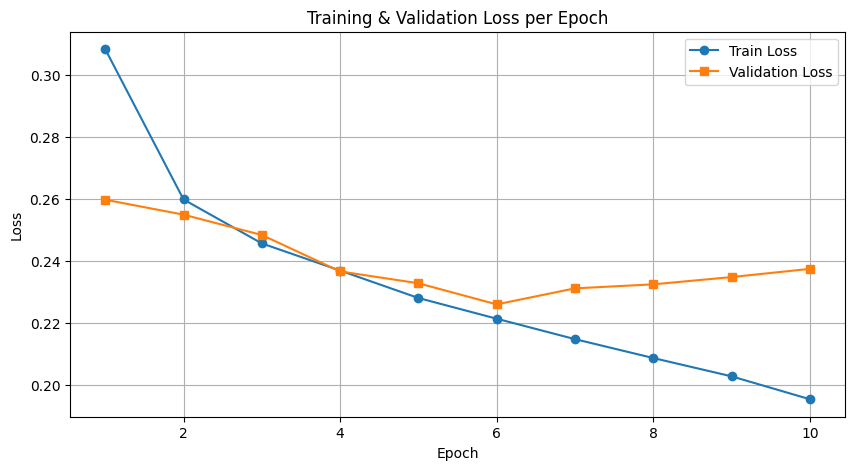

In [6]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

In [7]:
model_path = "vit_unet_oil_segmentation.pth"
model = load_model(model_path, device=device)
print(f"Model loaded from {model_path}")  

Model loaded from vit_unet_thesis_oil_segmentation_TRUE_testing_try2.pth


In [9]:
# 1) Metrics on Train set
train_miou, train_f1, train_precision, train_recall, train_accuracy = compute_metrics(model_path=model_path, dataloader=train_loader, device=device, threshold=0.5)
print(f"[Train] mIOU: {train_miou:.4f}, F1: {train_f1:.4f}, "
      f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, Accuracy: {train_accuracy:.4f}")

# 2) Metrics on Validation set
val_miou, val_f1, val_precision, val_recall, val_accuracy = compute_metrics(model_path=model_path, dataloader=val_loader, device=device, threshold=0.5)
print(f"[Val]   mIOU: {val_miou:.4f}, F1: {val_f1:.4f}, "
      f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, Accuracy: {val_accuracy:.4f}")

# 3) Combine train+val to get “full” dataset metrics
from torch.utils.data import ConcatDataset, DataLoader

full_dataset = ConcatDataset([train_dataset, val_dataset])
full_loader = DataLoader(full_dataset, batch_size=8, shuffle=False)

full_miou, full_f1, full_precision, full_recall, full_accuracy = compute_metrics(model_path=model_path, dataloader=full_loader, device=device, threshold=0.5)
print(f"[Full]  mIOU: {full_miou:.4f}, F1: {full_f1:.4f}, "
      f"Precision: {full_precision:.4f}, Recall: {full_recall:.4f}, Accuracy: {full_accuracy:.4f}")



[Train] mIOU: 0.8607, F1: 0.9251, Precision: 0.9152, Recall: 0.9352, Accuracy: 0.9596
[Val]   mIOU: 0.8154, F1: 0.8983, Precision: 0.8732, Recall: 0.9249, Accuracy: 0.9415
[Full]  mIOU: 0.8509, F1: 0.9195, Precision: 0.9062, Recall: 0.9331, Accuracy: 0.9560


In [ ]:
#randomly visuailize 
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_path = "vit_unet_oil_segmentation.pth"
    model = load_model(model_path, device=device)
    print(f"Model loaded from {model_path}")    

    # Call the visualization function
    visualize_segmentation(
        dataset=val_dataset, 
        model=model, 
        images_dir=val_images_dir, 
        num_samples=5, 
        threshold=0.5, 
        device=device)